TODO LONG-TERM
* Complete function documentation.
* Jail strategy is hard-coded as, in order, use a Get-Out-Of-Jail card, pay the fine, and roll the dice. In the future, strategy selection should be able to vary across players and be context-sensitive.
* Default method is simplistic. Need to code logic for what happens to defaulter's property.

### Import modules

In [22]:
# To be removed later
import time

# General
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

### Make declarations

In [23]:
VERBOSE = False

### Define functions

In [24]:
def get_players(n_players):
        
    assert n_players > 2, 'A game must have at least 2 players.'
    assert n_players < 8, 'A game must have no more than 8 players.'
    
    class Player(object):
        
        def __init__(self, player_id):
            self.id = player_id  # Identification number
            self.cash = 1500     # Cash on hand
            self.properties = [] # List of properties
            self.position = 0    # Board position
            self.jail_cards = 0  # Number of "Get Out Of Jail Free" cards
            self.jail_turns = 0  # Number of remaining turns in jail
            self.jail_strtg = '' # Jail strategy
        
        def move(self, roll):
            self.position += roll
            if self.position >= 40:
                self.position -= 40
                self.cash += 200
            if VERBOSE:
                print 'Player {} from position {} to {}'.format(self.id, self.position - roll, self.position)
        
        def evaluate_buy(self, prop):
            prop_has_owner = prop.owner is not None
            self_can_afford = self.cash >= prop.price
            if prop_has_owner:
                self.pay(players[prop.owner], prop.rent_now)
            elif ~prop_has_owner and self_can_afford:
                self.buy(prop)
        
        def evaluate_build(self):
            # Create a way to let players know when they have a monopoly
            # Create a way also of letting players know how many buildings they have
            # The second is a little tougher because you have to build them in a certain order
            # At first, just choose randomly
            # Then, they can start building their hotels as soon as they can
            pass
        
        def buy(self, prop):
            self.properties.append(prop.position)
            self.cash -= prop.price
            prop.owner = self.id
            if VERBOSE:
                print 'Player {} bought {}'.format(self.id, prop.name)
        
        def pay(self, other, payment):
            self.cash -= payment
            other.cash += payment
            if VERBOSE:
                print 'Player {} paid ${} to Player {}'.format(self.id, payment, other.id)
        
        def go_to_jail(self):
            self.position = 10
            self.jail_turns = 3
            if VERBOSE:
                print 'Player {} goes to jail'.format(self.id)
        
        def choose_jail_strtg(self, rolled_double):
            if self.jail_cards > 0:
                self.jail_strtg = 'card'
                self.jail_turns = 0
                self.jail_cards -= 1
            elif self.cash >= 50:
                self.jail_strtg = 'pay'
                self.jail_turns = 0
                self.cash -= 50
            else:
                self.jail_strtg = 'roll'
                if rolled_double:
                    self.jail_turns = 0
                else:
                    self.jail_turns -= 1
                    if self.jail_turns == 0:
                        self.cash -= 50
            if VERBOSE:
                print 'Player {} took jail strategy {} and has {} jail turns left'.format(self.id,
                                                                                          self.jail_strtg,
                                                                                          self.jail_turns)
                        
        def default(self):
            del players[self.id]
            
    return [Player(p) for p in range(n_players)]

In [25]:
def get_board(board_file):
        
    class Property(object):
        def __init__(self, name, position, price, rent):
            self.name = name
            self.position = position
            self.price = price
            self.price_mortgage = price / 2
            self.rent = rent
            self.rent_now = rent
            self.mortgage = False
            self.owner = None

    class Street(Property):
        def __init__(self, name, position, color, price, price_building, rent, rent_building, size_monopoly):
            Property.__init__(self, name, position, price, rent)
            self.color = color
            self.price_building = price_building
            self.rent_monopoly = rent * 2
            self.rent_building = rent_building
            self.size_monopoly = size_monopoly

    class Railroad(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_double = rent * 2
            self.rent_triple = self.rent_double * 2
            self.rent_monopoly = self.rent_triple * 2
            self.size_monopoly = 4
    
    class Utility(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_monopoly = rent + 6
            self.size_monopoly = 2
    
    class Tax(object):
        def __init__(self, price):
            self.price = price

    class Card(object):
        pass  
    
    class Chance(object):
        pass
    
    class Chest(object):
        pass
    
    class Jail(object):
        pass
    
    class Idle(object):
        pass
    
    board = []
    
    for _, r in pd.read_csv(board_file).iterrows():
        for case in switch(r['class']):
            if case('Street'):                
                board.append(Street(r['name'], r['position'], r['color'], r['price_buy'], r['price_build'], r['rent'],
                                    [r['rent_build_1'], r['rent_build_2'], r['rent_build_3'], r['rent_build_4'],
                                     r['rent_build_5']], r['size_monopoly']))
            elif case('Railroad'):
                board.append(Railroad(r['name'], r['position'], r['price_buy'], r['rent']))
            elif case('Utility'):
                board.append(Utility(r['name'], r['position'], r['price_buy'], r['rent']))
            elif case('Tax'):
                board.append(Tax(r['price_buy']))
            elif case('Chance'):
                board.append(Chance())
            elif case('Chest'):
                board.append(Chest())
            elif case('Jail'):
                board.append(Jail())
            elif case('Idle'):
                board.append(Idle())
    
    return board

In [26]:
def roll_dice(check_double=True):

    roll = np.random.choice(np.arange(1, 7), 2)
    
    if VERBOSE:
        print 'Die roll: {} and {}'.format(roll[0], roll[1])
    
    if check_double:
        return roll.sum(), roll[0] == roll[1]
    else:
        return roll.sum()

In [27]:
class switch(object):
    
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args:
            self.fall = True
            return True
        else:
            return False

### Play the game

<IPython.core.display.Javascript object>


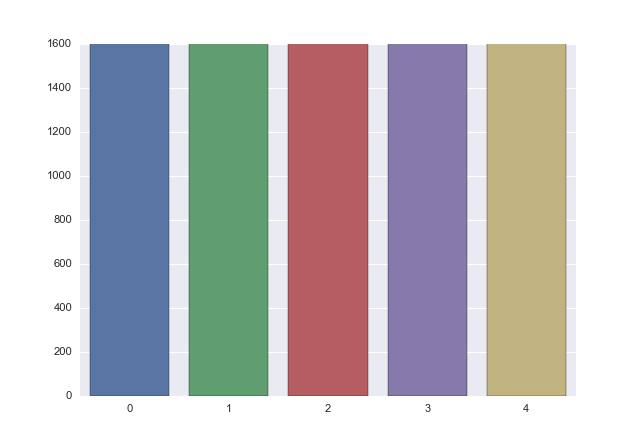

In [29]:
# Declarations
n_players = 5
board_file = 'board.csv'

# Get players and board (including properties)
players = get_players(n_players)
board = get_board(board_file)

# Start on round 1
game_round = 1

# Create figure and axis objects
fig, ax = plt.subplots(1, 1)

# Draw barplot
sns.barplot(y=[p.cash for p in players], x=[p.id for p in players], ax=ax)

# Start game
while len(players) > 1:

    # Take turns
    for turn in range(n_players):
        
        # Define current player
        curr_player = players[turn]

        # Double roll counter
        n_double_roll = 0

        # Continue turn until player rolls no doubles or goes to jail
        while True:

            # Roll dice
            roll, rolled_double = roll_dice()

            # Update double roll counter
            n_double_roll += (rolled_double).astype(int)

            # If player is in jail
            if players[turn].jail_turns > 0:

                # Select jail strategy
                curr_player.choose_jail_strtg(rolled_double)

                # If player is still in jail
                if curr_player.jail_turns > 0:
                    break

            # If player rolled less than 3 doubles
            if n_double_roll < 3:

                # Move player 
                curr_player.move(roll)
                
                # Define current board space
                curr_space = board[curr_player.position]
                                
                for case in switch(type(curr_space).__name__):
                    if case('Street') or case('Railroad') or case('Utility'):
                        curr_player.evaluate_buy(curr_space)

                # If no double rolled, end turn
                if not rolled_double:
                    break

            # Otherwise, send player to jail and end turn
            elif n_double_roll == 3:
                                
                curr_player.go_to_jail()
                break

            # Now here is where we start interacting with the board
            #type(board[4]).__name__
            
    game_round += 1
    
    # Update graph data
    for i, x in enumerate(ax.patches):
        x.set_height(players[turn].cash)
    
    # Draw updated graph
    fig.canvas.draw()

    if game_round == 50:
        break